In [1]:
import pandas as pd
import shap
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier, PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
# Load datasets
train_data = pd.read_csv(f'../dataset_classification/TrainDataset.csv')
test_data = pd.read_csv(f'../dataset_classification/TestDataset.csv')

#Clean TR from features
x_train = train_data.drop(columns = ["label", "position"])
y_train = train_data["label"]

#Split TR in TR and VL with HoldOut technique
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

#Clean TS from features
x_test = test_data.drop(columns = ["label", "position"])
y_test = test_data["label"]

FileNotFoundError: [Errno 2] No such file or directory: '../DatasetClassification/TrainDataset.csv'


Final evaluation

Train accuracy: 0.9306481105932309
Validation accuracy: 0.9303834754787779
Test accuracy: 0.9191109852774632

Train Log-Loss: 0.20168713488573695
Val Log-Loss: 0.20158424773982012
Test Log-Loss: 0.2296882778948858

Train AUC: 0.928080013746491
Val AUC: 0.9280299627540228
Test AUC: 0.8972057511748335

Starting SHAP analysis...


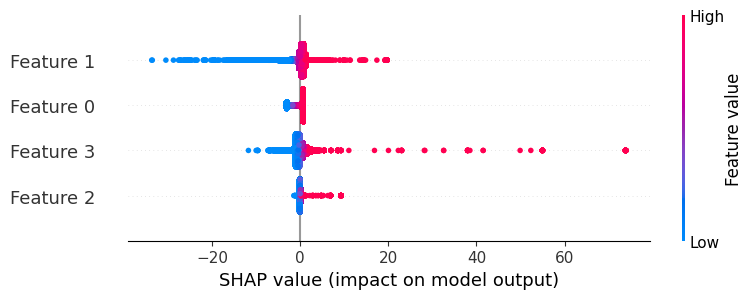

Finished SHAP analysis.
Starting SHAP analysis (foreach model)...


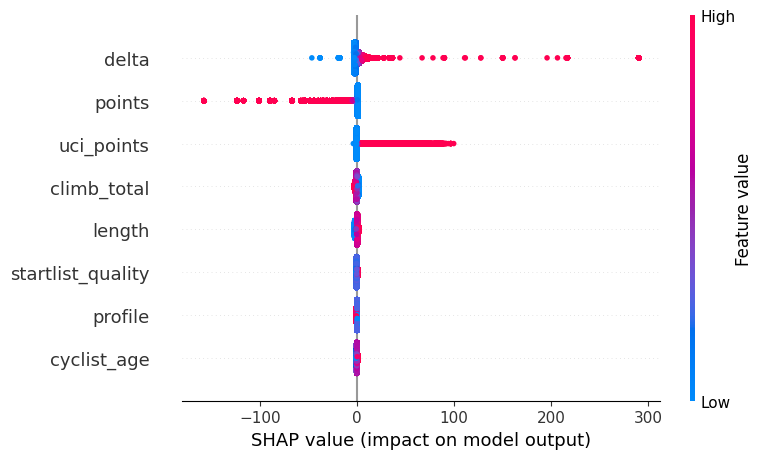

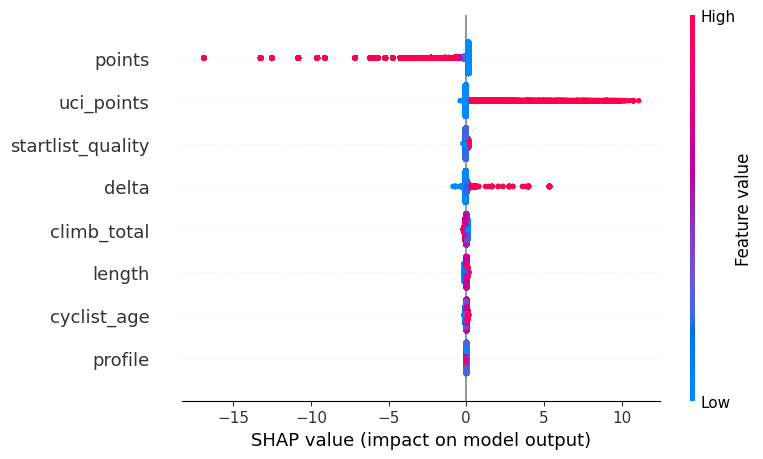

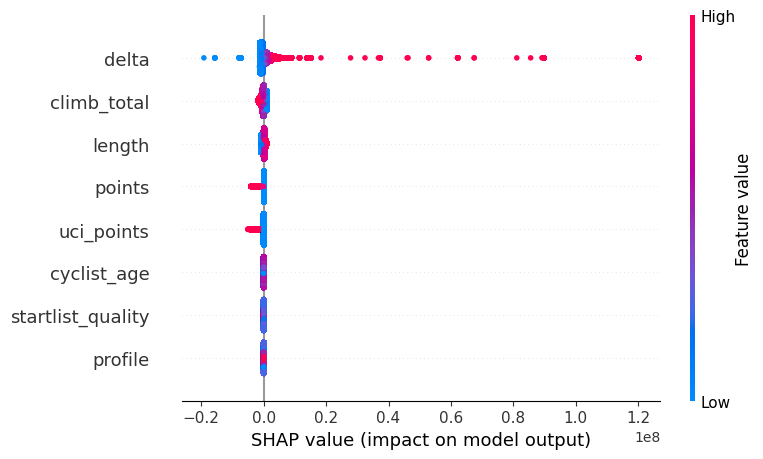

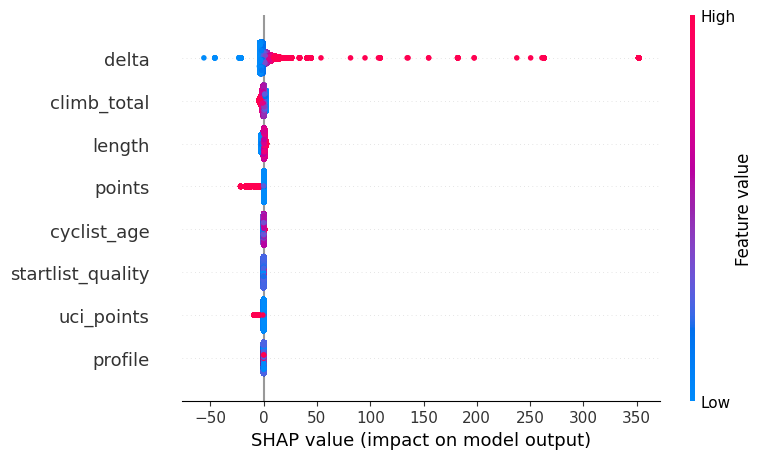

In [5]:
# Define base classifier
base_estimators = [
    ('logistic', LogisticRegression(max_iter=500, random_state=42)),
    ('ridge', RidgeClassifier(max_iter=500, random_state=42)),
    ('sgd', SGDClassifier(max_iter=500, tol=1e-3, random_state=42)),
    ('passive_aggressive', PassiveAggressiveClassifier(max_iter=500, tol=1e-3, random_state=42))
]

# Define meta classifier
meta_clf = LogisticRegression(max_iter=500, random_state=42)

# Create model
stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_clf,
    n_jobs=-1
)

# Train model
print("Starting training for StackingClassifier with linear models...")
stacking_clf.fit(x_train, y_train)
print("Finished training.")

# Evaluate model
print("")
print("Final evaluation")
print("")

train_accuracy = accuracy_score(y_train, stacking_clf.predict(x_train))
val_accuracy = accuracy_score(y_val, stacking_clf.predict(x_val))
test_accuracy = accuracy_score(y_test, stacking_clf.predict(x_test))

print(f"Train accuracy: {train_accuracy}")
print(f"Validation accuracy: {val_accuracy}")
print(f"Test accuracy: {test_accuracy}")
print("")

# Calculate log-loss
train_y_proba = stacking_clf.predict_proba(x_train)
val_y_proba = stacking_clf.predict_proba(x_val)
test_y_proba = stacking_clf.predict_proba(x_test)

train_loss = log_loss(y_train, train_y_proba)
val_loss = log_loss(y_val, val_y_proba)
test_loss = log_loss(y_test, test_y_proba)

print(f"Train Log-Loss: {train_loss}")
print(f"Val Log-Loss: {val_loss}")
print(f"Test Log-Loss: {test_loss}")
print("")

# Calculate AUC
train_auc = roc_auc_score(y_train, train_y_proba[:, 1])
val_auc = roc_auc_score(y_val, val_y_proba[:, 1])
test_auc = roc_auc_score(y_test, test_y_proba[:, 1])

print(f"Train AUC: {train_auc}")
print(f"Val AUC: {val_auc}")
print(f"Test AUC: {test_auc}")
print("")

# SHAP Integration -------------------------------------------------------------------
print("Starting SHAP analysis...")

# Apply SHAP analysis to meta classifier
x_meta_train = stacking_clf.transform(x_train)
explainer = shap.Explainer(stacking_clf.final_estimator_, x_meta_train)
shap_values = explainer(x_meta_train)

# Visualize SHAP analyze to meta classifier
shap.summary_plot(shap_values, x_meta_train)

print("Finished SHAP analysis.")

print("Starting SHAP analysis (foreach model)...")

for model in stacking_clf.estimators_:
    
    # Apply SHAP analysis to base classifier
    explainer = shap.Explainer(model, x_train)
    shap_values = explainer(x_train)
    
    # Visualize SHAP analyze to base classifier
    shap.summary_plot(shap_values, x_train)